<a href="https://colab.research.google.com/github/gettingbettersuhani/UIDAI-Project/blob/main/Biometric_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [2]:
# Load all Aadhaar biometric CSV chunks
df1 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv")
df2 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv")
df3 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv")
df4 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv")

# Merge all
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

print("Final shape:", df.shape)
df.head()


Final shape: (1861108, 6)


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


In [4]:
df.describe(include="all")

,date,state,district,pincode,bio_age_5_17,bio_age_17_
count,1861108,1861108,1861108,1.861108e+06,1.861108e+06,1.861108e+06
unique,89,57,974,NaN,NaN,NaN
top,25-12-2025,Tamil Nadu,Pune,NaN,NaN,NaN
freq,24646,184568,11586,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.217612e+05,1.839058e+01,1.909413e+01
std,NaN,NaN,NaN,1.981627e+05,8.370421e+01,8.806502e+01
min,NaN,NaN,NaN,1.100010e+05,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,3.911750e+05,1.000000e+00,1.000000e+00
50%,NaN,NaN,NaN,5.224010e+05,3.000000e+00,4.000000e+00
75%,NaN,NaN,NaN,6.866362e+05,1.100000e+01,1.000000e+01


In [5]:
missing = (df.isna().sum() / len(df)) * 100
missing.sort_values(ascending=False)

,0
date,0.0
state,0.0
district,0.0
pincode,0.0
bio_age_5_17,0.0
bio_age_17_,0.0


In [7]:
# Convert date
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# Create month-year feature
df["year_month"] = df["date"].dt.to_period("M")

df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,year_month
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,2025-03
1,2025-03-01,Bihar,Madhepura,852121,144,369,2025-03
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,2025-03
3,2025-03-01,Bihar,Bhojpur,802158,256,980,2025-03
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,2025-03


#REGION-LEVEL AGGREGATION (MONTHLY)

In [10]:
monthly = (
    df
    .groupby(["state", "district", "year_month"])
    .agg({
        "bio_age_5_17": "sum",
        "bio_age_17_": "sum"
    })
    .reset_index()
)

monthly.head()

,state,district,year_month,bio_age_5_17,bio_age_17_
0,Andaman & Nicobar Islands,Andamans,2025-03,16,193
1,Andaman & Nicobar Islands,Andamans,2025-04,17,167
2,Andaman & Nicobar Islands,Andamans,2025-05,22,158
3,Andaman & Nicobar Islands,Andamans,2025-06,11,129
4,Andaman & Nicobar Islands,Andamans,2025-07,20,239


#RATIO ENGINEERING

In [12]:
monthly["total_biometric_updates"] = monthly["bio_age_5_17"] + monthly["bio_age_17_"]

monthly["bio_age_5_17_ratio"] = (
    monthly["bio_age_5_17"] / monthly["total_biometric_updates"]
)

monthly["bio_age_17_plus_ratio"] = (
    monthly["bio_age_17_"] / monthly["total_biometric_updates"]
)

monthly.replace([np.inf, -np.inf], 0, inplace=True)
monthly.fillna(0, inplace=True)

monthly.head()

,state,district,year_month,bio_age_5_17,bio_age_17_,total_biometric_updates,bio_age_5_17_ratio,bio_age_17_plus_ratio
0,Andaman & Nicobar Islands,Andamans,2025-03,16,193,209,0.076555,0.923445
1,Andaman & Nicobar Islands,Andamans,2025-04,17,167,184,0.092391,0.907609
2,Andaman & Nicobar Islands,Andamans,2025-05,22,158,180,0.122222,0.877778
3,Andaman & Nicobar Islands,Andamans,2025-06,11,129,140,0.078571,0.921429
4,Andaman & Nicobar Islands,Andamans,2025-07,20,239,259,0.077220,0.922780


#BIOMETRIC RISK SCORE (0–1)

In [20]:
monthly["demographic_update_ratio"] = 0
monthly["child_enrolment_ratio"] = 0
monthly["fingerprint_update_ratio"] = 0
monthly["iris_update_ratio"] = 0

# Create a combined biometric update ratio from the available age-specific ratios
monthly["biometric_update_ratio"] = monthly["total_biometric_updates"]

# Normalize ratios
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Include all relevant ratio features, now all defined
risk_features = [
    "biometric_update_ratio",
    "demographic_update_ratio",
    "child_enrolment_ratio",
    "fingerprint_update_ratio",
    "iris_update_ratio"
]

monthly[risk_features] = scaler.fit_transform(monthly[risk_features])

# Composite biometric risk score
monthly["biometric_risk_score"] = (
    0.30 * monthly["biometric_update_ratio"] +
    0.25 * monthly["demographic_update_ratio"] +
    0.20 * monthly["child_enrolment_ratio"] +
    0.15 * monthly["fingerprint_update_ratio"] +
    0.10 * monthly["iris_update_ratio"]
)

monthly.head()

,state,district,year_month,bio_age_5_17,bio_age_17_,total_biometric_updates,bio_age_5_17_ratio,bio_age_17_plus_ratio,demographic_update_ratio,child_enrolment_ratio,fingerprint_update_ratio,iris_update_ratio,biometric_update_ratio,biometric_risk_score,target_next_month_risk
0,Andaman & Nicobar Islands,Andamans,2025-03,16,193,209,0.076555,0.923445,0.0,0.0,0.0,0.0,0.002337,0.000701,0.0
1,Andaman & Nicobar Islands,Andamans,2025-04,17,167,184,0.092391,0.907609,0.0,0.0,0.0,0.0,0.002056,0.000617,0.0
2,Andaman & Nicobar Islands,Andamans,2025-05,22,158,180,0.122222,0.877778,0.0,0.0,0.0,0.0,0.002011,0.000603,0.0
3,Andaman & Nicobar Islands,Andamans,2025-06,11,129,140,0.078571,0.921429,0.0,0.0,0.0,0.0,0.001561,0.000468,0.0
4,Andaman & Nicobar Islands,Andamans,2025-07,20,239,259,0.077220,0.922780,0.0,0.0,0.0,0.0,0.002898,0.000869,0.0


#Risk Score Distribution

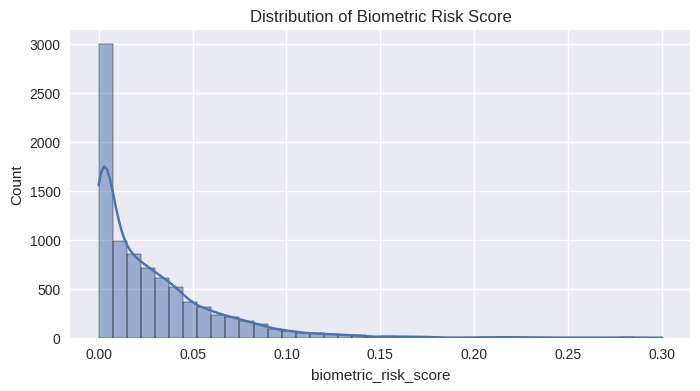

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(monthly["biometric_risk_score"], bins=40, kde=True)
plt.title("Distribution of Biometric Risk Score")
plt.show()


#Top High-Risk Districts

In [22]:
high_risk = (
    monthly
    .groupby(["state", "district"])["biometric_risk_score"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

high_risk

state           district        
Maharashtra     Pune                0.226830
                Nashik              0.215913
                Thane               0.213916
                Jalgaon             0.156290
Gujarat         Ahmedabad           0.151837
Maharashtra     Mumbai              0.151413
                Ahmadnagar          0.136136
Rajasthan       Jaipur              0.133261
Maharashtra     Nagpur              0.131403
Andhra Pradesh  Kurnool             0.131295
Maharashtra     Nanded              0.128264
                Amravati            0.126670
                Solapur             0.125256
                Yavatmal            0.122515
Delhi           North West Delhi    0.121806
Name: biometric_risk_score, dtype: float64

#Risk Trend Over Time

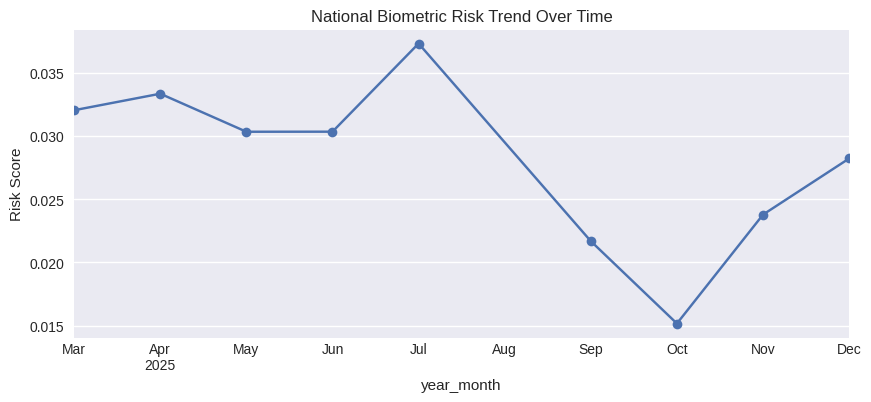

In [23]:
trend = (
    monthly
    .groupby("year_month")["biometric_risk_score"]
    .mean()
)

plt.figure(figsize=(10,4))
trend.plot(marker="o")
plt.title("National Biometric Risk Trend Over Time")
plt.ylabel("Risk Score")
plt.show()

#CORRELATION ANALYSIS

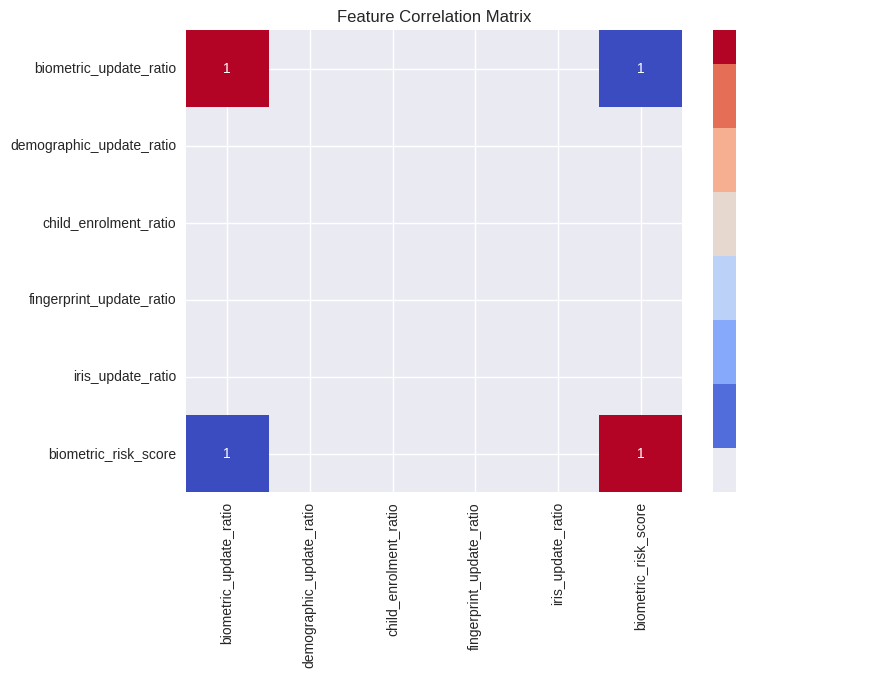

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(
    monthly[risk_features + ["biometric_risk_score"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Feature Correlation Matrix")
plt.show()

#Final

In [25]:
monthly = monthly.sort_values(["state", "district", "year_month"])

monthly["target_next_month_risk"] = (
    monthly
    .groupby(["state", "district"])["biometric_risk_score"]
    .shift(-1)
)

model_df = monthly.dropna()

model_df.head()

,state,district,year_month,bio_age_5_17,bio_age_17_,total_biometric_updates,bio_age_5_17_ratio,bio_age_17_plus_ratio,demographic_update_ratio,child_enrolment_ratio,fingerprint_update_ratio,iris_update_ratio,biometric_update_ratio,biometric_risk_score,target_next_month_risk
0,Andaman & Nicobar Islands,Andamans,2025-03,16,193,209,0.076555,0.923445,0.0,0.0,0.0,0.0,0.002337,0.000701,0.000617
1,Andaman & Nicobar Islands,Andamans,2025-04,17,167,184,0.092391,0.907609,0.0,0.0,0.0,0.0,0.002056,0.000617,0.000603
2,Andaman & Nicobar Islands,Andamans,2025-05,22,158,180,0.122222,0.877778,0.0,0.0,0.0,0.0,0.002011,0.000603,0.000468
3,Andaman & Nicobar Islands,Andamans,2025-06,11,129,140,0.078571,0.921429,0.0,0.0,0.0,0.0,0.001561,0.000468,0.000869
4,Andaman & Nicobar Islands,Andamans,2025-07,20,239,259,0.077220,0.922780,0.0,0.0,0.0,0.0,0.002898,0.000869,0.001065
